In [1]:
%load_ext watermark
%watermark -u -d -m -v -p numpy,matplotlib,iris,xarray,sattools,umtools,faamtools

last updated: 2016-08-18 

CPython 3.5.2
IPython 5.1.0

numpy 1.10.4
matplotlib 1.5.2
iris 1.9.2
xarray 0.8.1
sattools 0.1
umtools 0.1.5
faamtools 0.2.3

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 3.13.0-93-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
%matplotlib inline

In [3]:
import datetime
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import numpy as np
import os
import string
import xarray
#
import umtools.irismode as umi
import umtools.utils as umu
import sattools.avhrr as geotiff
from faamtools.core import parse_profiles_runs_info, read_core_nc
from faamtools.avaps import read_avaps_nc
#
import map_plot_func as mymap
import mypaths
import mpl_func as mympl
import plot_params as pp
import phys_meteo as met
import misc_utils as misc

In [33]:
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.family'] = 'sans-serif'

In [35]:
fmt = 'pdf'
svfigkw = dict(format=fmt, dpi=300, bbox_inches='tight')

In [4]:
uchar_list = list(string.ascii_uppercase)
lchar_list = list(string.ascii_lowercase)

In [5]:
pe = [PathEffects.withStroke(linewidth=1, foreground='w')]

In [6]:
iris.FUTURE.netcdf_promote = True
iris.FUTURE.cell_datetime_objects = True
um_res = umu.grdstep('km2p2')
fcst_init = '25_1200'

In [7]:
fcst_init_dt = datetime.datetime.strptime('201303'+fcst_init, '%Y%m%d_%H%M')

In [8]:
mapkw = dict(lon1=0,lon2=15,lat1=71,lat2=75,tick_incr=[2.,1.], resolution='c', scale=True)

In [9]:
mapbounds = (0, 15, 71., 75)

## Input data

### Aircraft data

In [10]:
faam = read_core_nc(mypaths.faamf, time2datetime=True)

In [11]:
fltime = faam.time.val

In [12]:
AB = range(0,11)
ds = [read_avaps_nc(mypaths.ds_flist[i], time2datetime=True) for i in AB]

In [13]:
fl_seg = parse_profiles_runs_info(os.path.join(mypaths.faamdir,'sawtooth_summary.txt'), daystr='20130326')
extra_points = []
for iseg, xsh, ysh in zip(fl_seg[1:5],[0.5,0.5,-0.5,-1],[0,0,-0.1,0]):
    i_end = np.argmin([abs(i.total_seconds()) for i in faam.time.val - datetime.datetime.strptime(iseg[2], '%Y%m%d%H%M%S')])
    extra_points.append(dict(lon=faam.lon.val[i_end]+xsh, lat=faam.lat.val[i_end]+ysh))
    
extra_points = [dict(name=i, **j) for i, j in zip(uchar_list, extra_points)]

### UM

In [26]:
def cleaner(cube, field, filename):
    try:
        cube.coord('time').var_name = 'time'
    except:
        pass
    for i_auxcoord in cube.aux_coords:
        if i_auxcoord.name() == u'forecast_period':
            cube.remove_coord(i_auxcoord)

In [15]:
fs = iris.load(os.path.join(mypaths.extdir, 'UM', 'exp_results', um_res.key, fcst_init, 'obs', 'processed', '*surf*11-14*proc*'), 
               callback=cleaner).concatenate()

In [20]:
u10m = fs.extract('x_wind', strict=True)
v10m = fs.extract('y_wind', strict=True)
lon2d, lat2d = umu.unrotate_xy_grids(u10m)
u10m, v10m = umi.unrotate_uv(u10m, v10m)

## Horizontal cross-sections of wind speed

####  ASCAT

In [22]:
ascat_data = xarray.open_dataset(mypaths.ascat_12km_flist[7])
um2ascat_gridratio = umu.convert_unit_str(um_res.to_str(), ascat_data.pixel_size_on_horizontal)

ascat_lons, ascat_lats = ascat_data.lon.values, ascat_data.lat.values
ascat_u, ascat_v = met.wswd2uv(ascat_data.wind_speed.values, ascat_data.wind_dir.values)

ascat_dt = ascat_data.time.values.astype('<M8[us]').astype(datetime.datetime)
ascat_mdt = mpl.dates.date2num(ascat_dt)

nearest_ascat_lon_ind = np.argmin(abs(lon2d[lon2d.shape[0]//2, lon2d.shape[1]//2] - ascat_lons[:, ascat_lons.shape[1]//2]))

In [23]:
the_time = ascat_dt[nearest_ascat_lon_ind, 0]

#### 4d arrays

In [24]:
files_wildcard = os.path.join(mypaths.extdir, 'UM', 'exp_results', um_res.key, fcst_init, 'obs', 'processed', 'umnsa_r*-proc*nc')

In [27]:
f_rholev = iris.load(files_wildcard, callback=cleaner).concatenate()

In [30]:
w = f_rholev.extract('upward_air_velocity', strict=True)
rhocoords = umi.get_model_real_coords(w, dims='tzyx')
u = f_rholev.extract('x_wind', strict=True)
v = f_rholev.extract('y_wind', strict=True)
u, v = umi.unrotate_uv(u, v)

In [31]:
u_lon2d, u_lat2d = umu.unrotate_xy_grids(w)

In [32]:
udata = u.extract(iris.Constraint(time=umu.nearest_tval(u, the_time))).data
vdata = v.extract(iris.Constraint(time=umu.nearest_tval(v, the_time))).data
um_wind_3d = met.uv2wspd(udata, vdata)
udata = u10m.extract(iris.Constraint(time=umu.nearest_tval(u10m, the_time))).data
vdata = v10m.extract(iris.Constraint(time=umu.nearest_tval(v10m, the_time))).data
um_wind_surf = met.uv2wspd(udata, vdata)

In [34]:
wspd_bounds = np.arange(3,27.1,3)
wspd_cmap = plt.cm.Oranges
wspd_norm = mpl.colors.BoundaryNorm(wspd_bounds, wspd_cmap.N)
conkw = dict(cmap=wspd_cmap, norm=wspd_norm, extend='max', latlon=True)
sckw = dict(cmap=wspd_cmap, norm=wspd_norm, rasterized=True, latlon=True, s=2**8, edgecolors='')
cbarkw = dict(orientation='horizontal', extend='neither', ticks=np.linspace(0,27,10))
quivkw = dict(color='k', scale=400, latlon=True) #edgecolors=('w'), linewidths=(0.25,), 

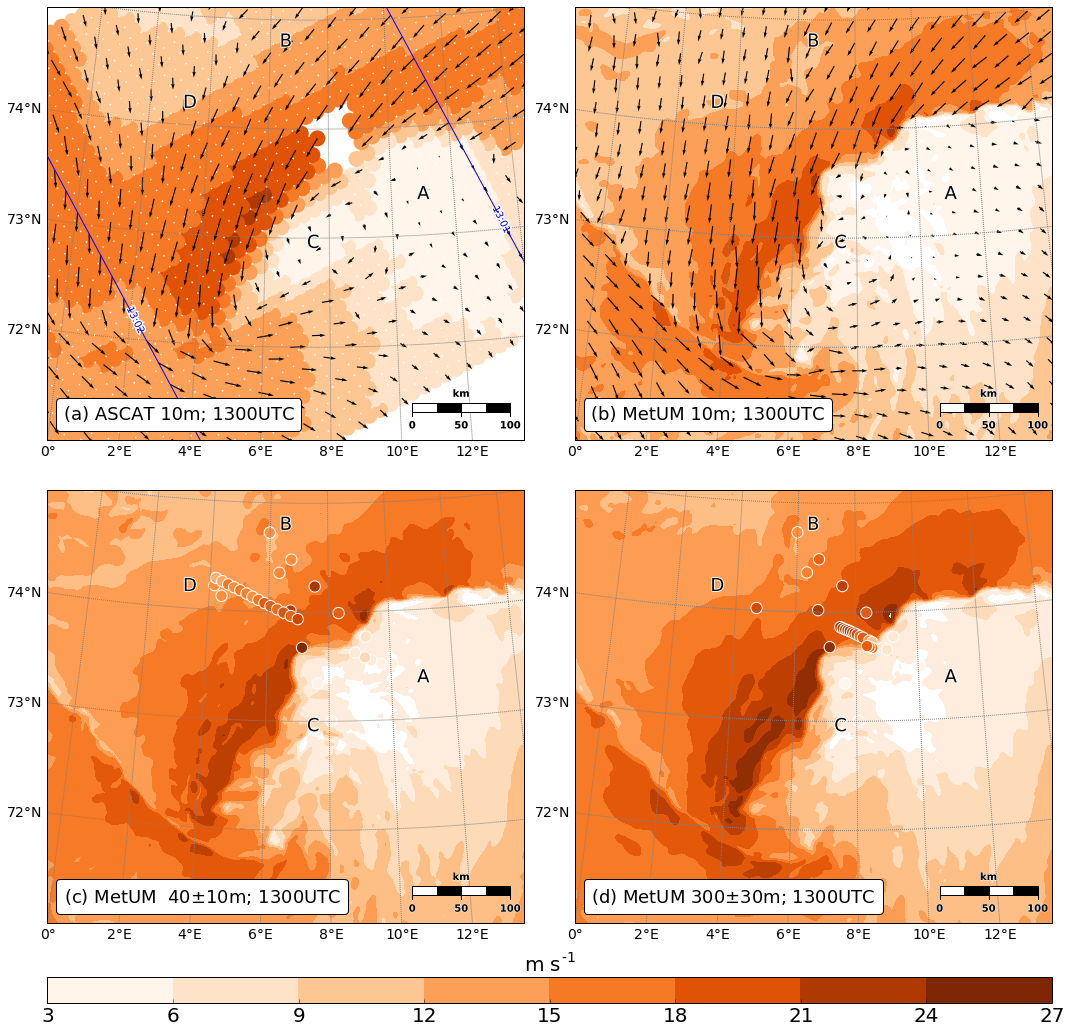

In [38]:
names = ['ASCAT 10m', 'MetUM 10m']
fig = plt.figure(figsize=(18,18))
grid = AxesGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.7, 
                cbar_location='bottom', cbar_mode='single', cbar_pad=0.05, cbar_size='3%')

iax = grid[0]
bm = mymap.make_map(ax=iax,**mapkw)
istride = 10
s = int(max(1,istride/1.5*um2ascat_gridratio))*2
c1 = bm.scatter(ascat_lons, ascat_lats, c=ascat_data.wind_speed.values, **sckw)
q = bm.quiver(ascat_lons[::s,::s], ascat_lats[::s,::s], ascat_u[::s,::s], ascat_v[::s,::s], 
              **quivkw)

gap_ind = np.argmax(abs(np.diff(ascat_lats[0,:])))
cc = bm.contour(ascat_lons[:,gap_ind+1:], ascat_lats[:,gap_ind+1:], ascat_mdt[:,gap_ind+1:], ascat_mdt[::30,0], colors='b', latlon=True, zorder=4)
ccl = plt.clabel(cc, inline=1, fmt=mpl.dates.DateFormatter('%H:%M'),colors='b')
plt.setp(ccl, path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
cc = bm.contour(ascat_lons[:,:gap_ind], ascat_lats[:,:gap_ind], ascat_mdt[:,:gap_ind], ascat_mdt[::30,0], colors='b', latlon=True, zorder=4)
ccl = plt.clabel(cc, inline=1, fmt=mpl.dates.DateFormatter('%H:%M'),colors='b')
plt.setp(ccl, path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])


iax = grid[1]
bm = mymap.make_map(ax=iax, **mapkw)
c2 = bm.contourf(lon2d, lat2d, um_wind_surf, levels=wspd_bounds,  **conkw) #levels=wspd_bounds, 
s = istride
q = bm.quiver(lon2d[::s,::s], lat2d[::s,::s], udata[::s,::s], vdata[::s,::s],
              **quivkw)


iax = grid[2]
height4anim = 40
dz = 10

varpack = dict(ax=iax, model=(u_lon2d, u_lat2d, um_wind_3d, rhocoords[1], u.coord('time')), ds_obs=(ds, 'wspd'), faam_obs=(faam, faam.wspd.val), 
               lims=('hgt',height4anim-dz, height4anim+dz), mapbounds=mapbounds)
c = mympl.horiz_sect_model_obs(varpack, clevs=wspd_bounds, av_slicing='z', add_colorbar=False, fill=False)
names.append('MetUM {z:3d}$\pm${dz:2d}m'.format(z=height4anim, dz=dz))

iax = grid[3]
height4anim = 300
dz = 30
varpack['ax'] = iax
varpack['lims'] = ('hgt', height4anim-dz, height4anim+dz)
c = mympl.horiz_sect_model_obs(varpack, clevs=wspd_bounds, av_slicing='z', add_colorbar=False, fill=False)
names.append('MetUM {z:3d}$\pm${dz:2d}m'.format(z=height4anim, dz=dz))

cb = plt.colorbar(c1, cax=grid.cbar_axes[0], **cbarkw)
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$m$ $s^{-1}$', fontsize=20)


for iax, lchar, name in zip(grid, lchar_list, names):
    txt = '({lab}) {name}; {dt}UTC'.format(lab=lchar, name=name, dt=the_time.strftime('%H%M'))
    at = AnchoredText(txt, prop=dict(size=18), frameon=True, loc=3)
    at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
    iax.add_artist(at)
    
    for p in extra_points:
        ix, iy = bm(p['lon'], p['lat'])
        iax.annotate(p['name'], (ix, iy), size=18, ha="center", color='k',
                     path_effects=[PathEffects.withStroke(linewidth=2,  foreground="w")])

imgname = 'ascat_vs_um_surf_40_300_{time}.{fmt}'.format(time=the_time.strftime('%Y%m%d_%H%M'), fmt=fmt)
fig.savefig(os.path.join('figures', imgname), **svfigkw)